# Prediksi Jangka Panjang Smart Climate Model (SCM)

## Install Packages

In [1]:
import pandas as pd # for dataframe
import numpy as np # for trigonometry and array
import scipy as sp # for fft
import matplotlib.pylab as plt # for plotting
import lmfit as lft # for least-square method
import calendar
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.cm import get_cmap
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import multiprocessing
import os
import glob
import gdal, osr
import numpy as np
from datetime import datetime, timedelta
import paramiko
import fnmatch

## Kerja di Lokal

In [2]:
#Cek data CHIRPS
path = 'D:\Works\Inovastek\DATABASE\SICA\Raw_Data\CHIRPS'
nc_list = glob.glob(path + '/*.tif')
nc_list

['D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198101.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198102.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198103.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198104.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198105.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198106.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198107.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198108.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198109.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198110.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198111.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198112.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198113.tif',
 'D:\\Works\\Inovastek\\DATABASE\\SICA\\Raw_Data\\CHIRPS\\198114.tif',
 'D:\\

## Definisi Fungsi FFT dan  Least-Square

In [3]:
"""FUNCTIONS DEFINITION"""
#INI DAH MULAI FFT 
# Function for least-square equation (All parameter should be defined separately)
def f10(x, w, a0, a1,a2, a3, a4, a5, a6, a7, a8, a9, a10, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10):
    return a0 + a1*np.cos(x*w) + a2*np.cos(2*x*w) + a3*np.cos(3*x*w) + a4*np.cos(4*x*w) + a5*np.cos(5*x*w) + a6*np.cos(6*x*w) + a7*np.cos(7*x*w) + a8*np.cos(8*x*w) + a9*np.cos(9*x*w) + a10*np.cos(10*x*w) + b1*np.sin(x*w) + b2*np.sin(2*x*w) + b3*np.sin(3*x*w) + b4*np.sin(4*x*w) + b5*np.sin(5*x*w) + b6*np.sin(6*x*w) + b7*np.sin(7*x*w) + b8*np.sin(8*x*w) + b9*np.sin(9*x*w) + b10*np.sin(10*x*w)

# Function for testing model using Fourier Series equation following f10 format
def test_fourier(y_data, x_data, n_data, n_order, n_trial, w_value, parameter):        
    # Slice y and x data based on n_data value
    y = y_data[0:n_data]
    x = x_data[0:n_data]

    # Get number of parameter
    n_parameter = len(parameter[0])

    # List initialisation
    total = [ [0]*n_data for _ in range(n_trial)]
    rmse = [0 for _ in range(n_trial)]
    rsquare = [0 for _ in range(n_trial)]
    residual = [0 for _ in range(n_trial)]
    
    best_parameter = [0 for _ in range(n_parameter)]
    best_result = [0 for _ in range(n_data)]
    best_residual = [0 for _ in range(n_data)]
    
    # Test the function for each frequency
    for trial in range(n_trial):
        
        # Calculate the function result for each x
        for ts in range(n_model):        
            total[trial][ts] = parameter[trial][0]                
            for order in range(1, n_order+1):            
                total[trial][ts] = total[trial][ts] + parameter[trial][order] * np.cos(order*w_value[trial]*x[ts]) + parameter[trial][order+n_order] * np.sin(order*w_value[trial]*x[ts])        
        
        # Get the residuals and statistics
        residual[trial] = list(np.array(y) - np.array(total[trial]))
        rmse[trial] = np.sqrt(((np.array(y) - np.array(total[trial])) ** 2).mean())
        _, _, rsquare[trial], _, _ = sp.stats.linregress(y, total[trial])
                
        # Finding the best frequency based on rmse and rsquare
        if trial == 0:            
            best_result = total[trial]            
            best_residual = residual[trial]
            best_frequency = w_value[trial]
            best_parameter = parameter[trial]
            best_rmse = rmse[trial]
            best_rsquare = rsquare[trial]            
        else:
            if rmse[trial] < 40:
                if rsquare[trial] > best_rsquare:                            
                    best_result = total[trial]
                    best_residual = residual[trial]
                    best_frequency = w_value[trial]
                    best_parameter = parameter[trial]
                    best_rmse = rmse[trial]
                    best_rsquare = rsquare[trial]                    
    
    if GRAPH:
        print("Original and Testing Data:")
        plt.plot(y, 'k')
        plt.plot(best_result, 'r')
        plt.show()
    
    return best_result, best_residual, best_frequency, best_parameter, best_rmse, best_rsquare

# Function to forecast using n_order-order Fourier Series equation following f10 format
def forecast_fourier(x_data, n_data, n_order, w_value, parameter):
    x = x_data
    total = [0 for _ in range(n_data)]
                
    for ts in range(n_data):        
        total[ts] = parameter[0]                
        for order in range(1, n_order+1):            
            total[ts] = total[ts] + parameter[order] * np.cos(order*w_value*x[ts]) + parameter[order+n_order] * np.sin(order*w_value*x[ts])                          
        
    return total

# Function to train a fitting equation
def train(y_data, x_data, n_data, n_trial, train_model, train_parameter, n_parameter, GRAPH, DEBUG):
    # Slice y and x data based on n_data value
    y = y_data[0:n_data]
    x = x_data[0:n_data]
    
    # FFT to obtain wave spectrum of each frequency
    dt= 1
    fft = np.fft.fft(y)
    fft_freq_all = np.fft.fftfreq(n_data, dt)
    
    fft_freq_indices = np.where(fft_freq_all > 0)
    fft_freq_pos = fft_freq_all[fft_freq_indices]
    fft_period = 1/fft_freq_pos
    fft_power = np.abs(fft[fft_freq_indices])**2
    fft_power_sorted = sorted(list(fft_power), reverse=True)
    
    # Get n_trial strongest frequency and n_trial*n_parameter parameter value
    train_variables = [ [0]*n_parameter for _ in range(n_trial) ]
    train_freq = [ 0 for _ in range(n_trial) ]
        
    for trial in range(n_trial):            
        train_freq[trial] = 2 * np.pi * fft_freq_pos[list(fft_power).index(fft_power_sorted[trial])]            
        train_object = train_model.fit(y, train_parameter, x=x, w=train_freq[trial])
        train_variables[trial] = list(train_object.best_values.values())    

    # Show graph if opted 
    if GRAPH:        
        print("FFT Graph:")
        plt.plot(fft_period, fft_power)
        plt.show()
                
    return train_freq, train_variables

In [4]:
# ngecek package GDAl jalan atau nggak
# Dicek dulu ukuran arraynya buat iterasinya cuk
fname = 'D:/Works/Inovastek/DATABASE/SICA/Raw_Data/CHIRPS/198101.tif'
#fname = 'C:/Raw_Data/CHIRPS/198101.tif'

tiff = gdal.Open(fname)
layer_lat = np.zeros(shape = (640,1480))
layer_lon = np.zeros(shape = (640,1480))
grid_geotransform = tiff.GetGeoTransform()

for y in range(0,640):
    for x in range(0,1480):
        layer_lon[y,x] = grid_geotransform[0] + x*grid_geotransform[1]        
        layer_lat[y,x] = grid_geotransform[3] + y*grid_geotransform[5]

data = tiff.ReadAsArray()

In [7]:
year_awal = 2014
year_akhir= 2018
n_year = year_akhir - year_awal + 1

In [8]:
n_year

5

In [9]:
"""DATA PREP"""
# os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'
# os.environ['PROJ_LIB'] = os.environ['CONDA_PREFIX'] + r'\Library\share'

gdal.UseExceptions()

#lat_max = 2.5 #350
#lat_min = -0.95 #420
#lon_max = 115.45 #510
#lon_min =112 #440

#n_year = 30
#n_year = 1
#n_ts = n_year * 12 * 3
n_ts = 163
layer_rain = np.zeros(shape = (640,1480,n_ts))
layer_lat = np.zeros(shape = (640,1480))
layer_lon = np.zeros(shape = (640,1480))

ts = -1

for year in range (year_awal, year_akhir + 1):
#for year in range (2018, 2019):
    for month in range (1, 37):
        ts = ts + 1
        
        if month < 10:
            datestring = str(year) + "0" + str(month)
        else:
            datestring = str(year) + str(month)
            
        print(datestring)
        
        fname = 'D:/Works/Inovastek/DATABASE/SICA/Raw_Data/CHIRPS/' + datestring + '.tif'
        
        tiff = gdal.Open(fname)
        
        if ts == 0:
            grid_geotransform = tiff.GetGeoTransform()

            for y in range(0,640):
                for x in range(0,1480):
                    layer_lon[y,x] = grid_geotransform[0] + x*grid_geotransform[1]        
                    layer_lat[y,x] = grid_geotransform[3] + y*grid_geotransform[5]
        
        data = tiff.ReadAsArray()
        
        layer_rain[:,:,ts] = data

layer_rain[layer_rain == -32768] = -9999

201401
201402
201403
201404
201405


KeyboardInterrupt: 

In [7]:
from tqdm import tqdm

In [12]:
layer_data = np.dstack((layer_lon,layer_lat))
layer_data = np.concatenate((layer_data, layer_rain), axis = 2)
#for ts in range(n_ts):
#    print(ts)
#    layer_data = np.dstack((layer_data,layer_rain[:,:,ts]))
    
layer_data = layer_data.reshape(-1,layer_data.shape[2])
layer_data = layer_data[~np.isnan(layer_data).any(axis=1)]

#np.savetxt("chirps_pama_19922022_evals_02.csv", layer_data, delimiter=",", fmt='%.2f')

MemoryError: Unable to allocate 5.10 GiB for an array with shape (947200, 722) and data type float64

In [8]:
#workpath_data = 'D:\Works\Inovastek\DATABASE\PAMA\Jangka Panjang Agustus'
#layer_data = pd.read_csv(workpath_data + '\df_data_pama_202207.csv')
workpath_data = 'D:\Works\Inovastek\Trial Bukit Asam'
layer_data = pd.read_csv(workpath_data + '\data_BA2.csv')

In [9]:
df_data = layer_data

In [10]:
df_data

,0,1,17,18,19,20,21,22,23,24,...,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096
0,103.80,-3.75,52,16,7,44,111,31,65,49,...,86,101,133,82,76,107,176,92,63,129
1,103.85,-3.75,58,15,14,53,109,32,79,40,...,83,102,138,83,77,107,176,92,63,135
2,103.80,-3.80,52,16,7,44,114,32,64,49,...,80,95,128,80,75,99,171,94,73,127
3,103.85,-3.80,57,16,14,54,112,33,80,40,...,82,98,132,78,73,98,169,91,64,129


In [10]:
#cek_df = pd.DataFrame(layer_data)
cek_df = layer_data
lon = 114.4 #Titik Tinjau
lat = -0.975 #Titik Tinjau
a = cek_df['1'].sub(lat).abs() + cek_df['0'].sub(lon).abs()

In [11]:
index = a.idxmin()
df = pd.DataFrame(layer_data)
df_data = df.iloc[index]
df_data = pd.DataFrame(df_data).transpose()

In [12]:
df_data

,0,1,23,24,25,26,27,28,29,30,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
428,114.4,-0.95,49.0,18.0,93.0,159.0,64.0,89.0,135.0,53.0,...,167.0,128.0,178.0,138.0,91.0,103.0,114.0,74.0,41.0,25.0


In [13]:
df_data.reset_index(inplace=True)
df_data.drop(['index'], axis=1)

,0,1,23,24,25,26,27,28,29,30,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
0,114.4,-0.95,49.0,18.0,93.0,159.0,64.0,89.0,135.0,53.0,...,167.0,128.0,178.0,138.0,91.0,103.0,114.0,74.0,41.0,25.0


In [14]:
#workpath = "/Works/Inovastek/DATABASE/PAMA/Script/IPYNB/"
#df_data_1 = pd.read_csv(workpath + 'PAMA_BARU_KALTENG.csv', delimiter=',', header=None) # Set this according to your data name

In [15]:
#df_data = df_data_1.loc[(df_data_1[0]==114.4) & (df_data_1[1]==-0.95)]
#df_data = df_data.drop([0,1,2], axis=1)
#df_data = df_data.reset_index().drop('index', axis=1)

In [11]:
# Get dataframe properties
n_header = 2 # Set this according to your data
n_site = int(df_data.shape[0]) # Get dataframe rows
n_dataframe = int(df_data.shape[1] - n_header) # Get dataframe column
n_year, _ = divmod(n_dataframe, 36) # Get n of years

# Timeseries data properties
n_dataseries = int(n_dataframe/12) # n of the data length (data are separated into months)
n_test = 3 # n of data length (in decads) for testing (3 decads = 1 year)
n_train = int(n_dataseries - n_test) # n of data length (in decads) for training
n_model = int(n_dataseries) # n of data length (in decads) for test

n_forecast_year = 1  # n of year for forecast
n_forecast_decad = n_forecast_year * 3 # n of forecast decad per month
n_forecast_series = int(n_dataseries + n_forecast_decad) # n of data length for forecast (data are separated into months)

n_order = 10 # n of fourier order
n_trial = 5 # n of strongest power spectrum for train
n_parameter = 21 # n of parameter of train equation (n of parameter is train function)

# Set run properties
GRAPH = False # Set True to see graphs
DEBUG = False # Set True to see more statistics

# Get data header for forecast dataframe
df_forecast = df_data.iloc[:,:n_header]
df_forecast = df_forecast.T

# Create array for testing and forecasting result
forecast_result = np.zeros([n_forecast_series * 12, n_site])
test_result = np.zeros([n_dataframe, n_site])

test_rmse = np.zeros(n_site)
test_rsquare = np.zeros(n_site)

train_rmse = np.zeros(n_site)
train_rsquare = np.zeros(n_site)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Lokasi:  0
---------------------------------
Site Training RMSE:  30.270057339964932
Site Training RSQ:  0.815891481056374
Site Testing RMSE:  35.01380767432613
Site Testing RSQ:  0.5895643360460807
Forecast Graph:


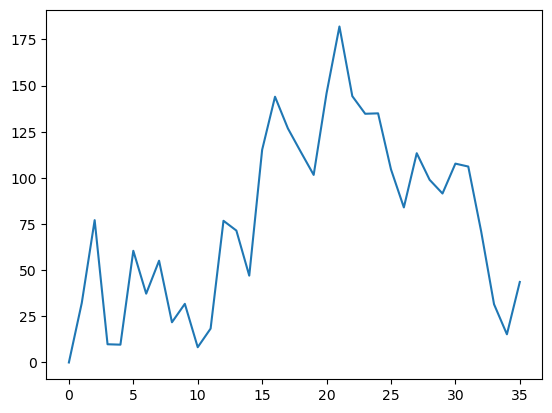

 25%|█████████████████████                                                               | 1/4 [00:08<00:26,  8.74s/it]

Lokasi:  1
---------------------------------
Site Training RMSE:  30.278388750532837
Site Training RSQ:  0.8169810221002852
Site Testing RMSE:  35.23615432390823
Site Testing RSQ:  0.6187627685127366
Forecast Graph:


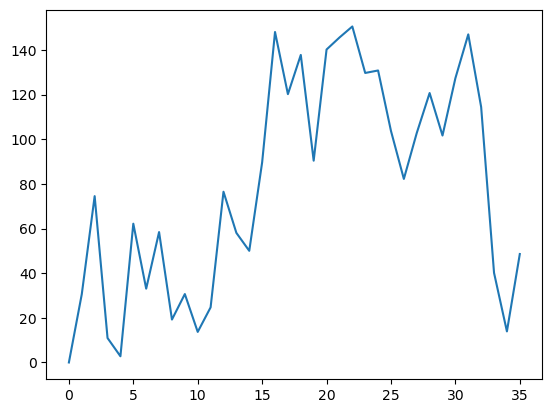

 50%|██████████████████████████████████████████                                          | 2/4 [00:17<00:17,  8.80s/it]

Lokasi:  2
---------------------------------
Site Training RMSE:  30.230796827432314
Site Training RSQ:  0.8144438990288558
Site Testing RMSE:  33.80956433289437
Site Testing RSQ:  0.6025656020669251
Forecast Graph:


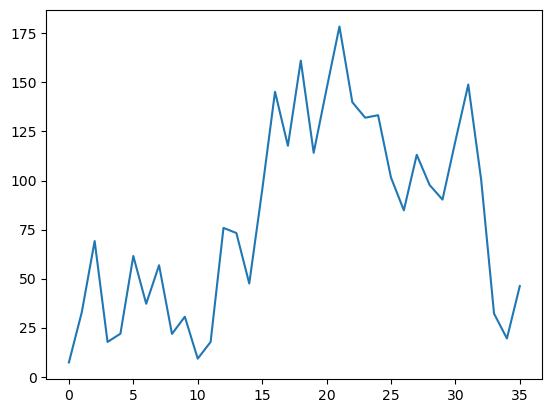

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:25<00:08,  8.55s/it]

Lokasi:  3
---------------------------------
Site Training RMSE:  30.05064353082635
Site Training RSQ:  0.8174869198411965
Site Testing RMSE:  37.75497062801171
Site Testing RSQ:  0.5442616537316325
Forecast Graph:


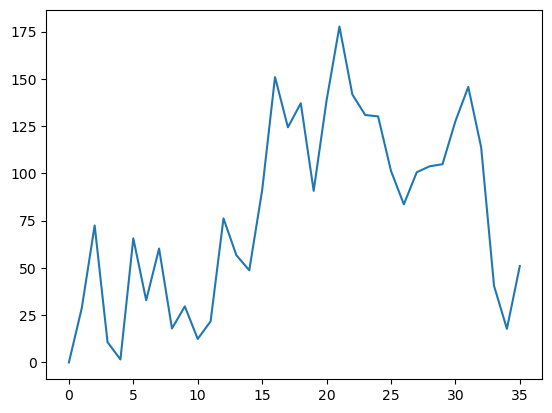

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.66s/it]


In [12]:
# Calculate forecast starting from each location
for site in tqdm(range(n_site)):
    
    print("==================================")
#    print("Lokasi: ", df_data.iloc[site,0])
    print("Lokasi: ", site)
    print("---------------------------------")
    
    # Create array for testing result, rmse, and rsquare
    test_result_monthly = np.zeros((12,n_dataseries))
    test_rmse_monthly = np.zeros(12)
    test_rsquare_monthly = np.zeros(12)
    
    # Create array for monthly forecast result
    forecast_result_monthly = np.zeros((12,n_forecast_series))
    
    # Find historical maximum rainfall
    data_max = max(df_data.iloc[site, n_header:])
    
    # Calculate forecast for each month in a location
    for month in range(12):
        
        if DEBUG:
            print("Month: ", month+1)
            
        # Create list for location of the data
        data_loc = [n_header+(36*year)+(3*month)+decad for year in range(n_year) for decad in range(3)]
        
        # Get the data
        data_y = df_data.iloc[site, data_loc]
        data_y = data_y.tolist()
        
        # Create x data
        data_x = [n_header+(36*year)+(3*month)+decad for year in range(n_year) for decad in range(3)]
        
        # Base training and testing
        base_model = lft.Model(f10, independent_vars=['x', 'w'])
        base_params = base_model.make_params(a0=0, a1=0, a2=0, a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0, b1=0, b2=0, b3=0, b4=0, b5=0, b6=0, b7=0, b8=0, b9=0, b10=0)    
        base_trial_freqs, base_trial_paramsval = train(data_y, data_x, n_train, n_trial, base_model, base_params, n_parameter, GRAPH, DEBUG)
        base_result, base_residual, base_freqs, base_paramsval, base_rmse, base_rsquare = test_fourier(data_y, data_x, n_model, n_order, n_trial, base_trial_freqs, base_trial_paramsval)
        
        # Anomaly training and testing
        anomaly_model = lft.Model(f10, independent_vars=['x', 'w'])
        anomaly_params = anomaly_model.make_params(a0=0, a1=0, a2=0, a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0, b1=0, b2=0, b3=0, b4=0, b5=0, b6=0, b7=0, b8=0, b9=0, b10=0)
        anomaly_trial_freqs, anomaly_trial_paramsval = train(base_residual, data_x, n_train, n_trial, anomaly_model, anomaly_params, n_parameter, GRAPH, DEBUG)
        anomaly_result, anomaly_residual, anomaly_freqs, anomaly_paramsval, anomaly_rmse, anomaly_rsquare = test_fourier(base_residual, data_x, n_model, n_order, n_trial, anomaly_trial_freqs, anomaly_trial_paramsval)
                
        # Calculate monthly test result statistics
        test_result_monthly[month] = np.array(base_result) + np.array(anomaly_result)
        test_rmse_monthly[month] = np.sqrt(((data_y - test_result_monthly[month]) ** 2).mean())
        _, _, test_rsquare_monthly[month], _, _ = sp.stats.linregress(data_y, test_result_monthly[month])
    
        if DEBUG:                    
            print("RMSE: ", test_rmse_monthly[month])
            print("RSQ: ", test_rsquare_monthly[month])
            print("---------------------------------")
        
        # Calculate forecast
        forecast_x = [n_header+(36*year)+(3*month)+decad for year in range(n_year+n_forecast_year) for decad in range(3)]
        forecast_result_monthly[month] = np.array(forecast_fourier(forecast_x,n_forecast_series,n_order,base_freqs,base_paramsval)) + np.array(forecast_fourier(forecast_x,n_forecast_series,n_order,anomaly_freqs,anomaly_paramsval))
        forecast_result_monthly[forecast_result_monthly < 0] = 0
        forecast_result_monthly[forecast_result_monthly > data_max] = data_max
    
    # Reshape test result into location-timeseries array
    i = 0   
    for year in range(n_year):
        for month in range(12): # Row        
            for decad in range(3):
                test_result[i, site] = test_result_monthly[month,(3*year)+decad]            
                i = i+1
    
    # Calculate final train result statistics
#    train_y = df_data.iloc[site, n_header:n_header+n_train]
#    train_rmse = np.sqrt(((train_y - test_result[:n_train*12,site]) ** 2).mean())
#    _, _, train_rsquare, _, _ = sp.stats.linregress(train_y, test_result[:n_train*12,site])
    
    # Calculate final test result statistics
    train_y = df_data.iloc[site, n_header:n_header+n_train*12]
    train_y = train_y.tolist()
    train_rmse[site] = np.sqrt(((train_y - test_result[:n_train*12,site]) ** 2).mean())
    _, _, train_rsquare[site], _, _ = sp.stats.linregress(train_y, test_result[:n_train*12,site])
    
    test_y = df_data.iloc[site, n_header+n_train*12:]
    test_y = test_y.tolist()     
    test_rmse[site] = np.sqrt(((test_y - test_result[n_train*12:,site]) ** 2).mean())
    _, _, test_rsquare[site], _, _ = sp.stats.linregress(test_y, test_result[n_train*12:,site])
        
    print("Site Training RMSE: ", train_rmse[site])
    print("Site Training RSQ: ", train_rsquare[site])
    print("Site Testing RMSE: ", test_rmse[site])
    print("Site Testing RSQ: ", test_rsquare[site])
    
    # Reshape forecast result into location-timeseries array
    i = 0
    for year in range(n_year + n_forecast_year):
        for month in range(12): # Row        
            for decad in range(3):
                forecast_result[i, site] = forecast_result_monthly[month,(3*year)+decad]
                i = i+1                
                
    print("Forecast Graph:")
    plt.plot(forecast_result[n_dataframe:n_forecast_series*12, site])
    plt.show()

In [13]:
cek = pd.DataFrame(forecast_result)
forecast_result = forecast_result.astype(int)
forecast_result = pd.DataFrame(forecast_result[n_dataframe:n_forecast_series*12, :])
df_forecast = df_forecast.append(forecast_result, ignore_index=True)
df_forecast = df_forecast.T

In [14]:
df_forecast = df_forecast.drop([0,1], axis=1)
df_forecast = df_forecast.T

In [15]:
df_forecast

,0,1,2,3
2,0.0,0.0,7.0,0.0
3,32.0,30.0,32.0,28.0
4,77.0,74.0,69.0,72.0
5,9.0,10.0,17.0,10.0
6,9.0,2.0,21.0,1.0
7,60.0,62.0,61.0,65.0
8,37.0,33.0,37.0,32.0
9,55.0,58.0,56.0,60.0
10,21.0,19.0,21.0,17.0
11,31.0,30.0,30.0,29.0


In [11]:
df_forecast.to_csv('Bukit Asam.csv')

NameError: name 'df_forecast' is not defined

In [12]:
import netCDF4 as nc
filepath = 'D:\Works\Inovastek\Trial Bukit Asam\CMIP-5.nc'
nc_cmip = nc.Dataset(filepath)

In [13]:
nc_cmip

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    title: NOAA GFDL GFDL-CM3, RCP8.5 (run 1) experiment output for CMIP5 AR5
    institute_id: NOAA GFDL
    source: GFDL-CM3 2010 atmosphere: AM3 (AM3p9,C48L48); sea ice: SIS (SISp2,Tripolar360x200); land: LM3 (LM3p7_cCM3,C48); ocean: MOM4 (MOM4p1_x1_Z50_cCM3,Tripolar360x200L50)
    contact: gfdl.climate.model.info@noaa.gov
    project_id: CMIP5
    table_id: Table day (31 Jan 2011)
    experiment_id: rcp85
    realization: 1
    modeling_realm: atmos
    tracking_id: 8f211a4e-8f88-4bde-a6c8-7c86681337dc
    Conventions: CF-1.4
    references: The GFDL Data Portal (http://nomads.gfdl.noaa.gov/) provides access to NOAA/GFDL's publicly available model input and output data sets. From this web site one can view and download data sets and documentation, including those related to the GFDL coupled models experiments run for the IPCC's 5th Assessment Report and the US CCSP.
    comment: GF

In [14]:
nc_time = nc_cmip['time'][:]
nc_lon = nc_cmip['lon'][:]
nc_lat = nc_cmip['lat'][:]

In [15]:
nc_time = nc_time.compressed()
nc_lon = nc_lon.compressed()
nc_lat = nc_lat.compressed()

In [16]:
temp = []
temp2 = []
lon = 103.824
lat = -3.77
for i in range (len(nc_lon)):
    temp.append(abs(lon - nc_lon[i]))
for i in range (len(nc_lat)):
    temp2.append(abs(lat - nc_lat[i]))

In [17]:
lon_idx = temp.index(min(temp))
lat_idx = temp2.index(min(temp2))

In [18]:
lon_idx

41

In [19]:
lat_idx

43

In [ ]:
#Indeks CMIP 525 - 555

In [103]:
cek = nc_cmip['pr'][525:556,lat_idx,lon_idx]

In [104]:
cek = cek.compressed()

In [105]:
cek

array([9.51431230e-06, 2.38344510e-05, 5.07911172e-05, 1.05420295e-05,
       6.11785572e-06, 9.48375691e-06, 1.14784480e-05, 2.60008037e-05,
       3.13734963e-05, 2.33171686e-05, 2.95193040e-05, 2.74157301e-05,
       1.25891065e-05, 1.31287413e-06, 7.79983657e-06, 1.95072789e-06,
       1.64216829e-07, 5.25248538e-07, 5.10498239e-06, 2.68526310e-06,
       3.80227334e-07, 2.62939898e-06, 5.48515254e-06, 2.73578894e-06,
       1.26239329e-05, 1.11079298e-05, 9.52043865e-06, 7.97452685e-06,
       5.10288555e-05, 1.85965462e-07, 6.58842396e-07], dtype=float32)

In [21]:
workpath = 'D:\Works\Inovastek\DATABASE\PAMA\Jangka Panjang Agustus'
prec = pd.read_csv(workpath+'\CMIP-Agustus.csv')
wadah = prec
wadah['konversi'] = np.nan

In [22]:
df_forecast = df_forecast.reset_index()
df_forecast = df_forecast.drop('index', axis=1)
scm_pama = df_forecast

In [23]:
for i in range(len(scm_pama)):
    sum10 = np.sum(wadah.loc[(i*10):(i+1)*10, 'Prec'])
    print(f'index {i*10} ke {(i+1)*10} : {sum10}')
    
    for j in range(i*10,(i+1)*10):
        wadah.loc[j, 'konversi'] = (wadah.loc[j, 'Prec']/sum10)*scm_pama.loc[i,0]

index 0 ke 10 : 0.0004424405734
index 10 ke 20 : 0.000190055441
index 20 ke 30 : 4.1406884e-05
index 30 ke 40 : 1.336989e-05
index 40 ke 50 : 0.0003549047182
index 50 ke 60 : 0.000228162769
index 60 ke 70 : 0.00031265000000000004
index 70 ke 80 : 0.0005288490000000001
index 80 ke 90 : 0.00045739500000000003
index 90 ke 100 : 0.000428595
index 100 ke 110 : 0.00028276
index 110 ke 120 : 0.000463089
index 120 ke 130 : 0.00088932846
index 130 ke 140 : 0.001179867
index 140 ke 150 : 0.001780619
index 150 ke 160 : 0.0015326299999999999
index 160 ke 170 : 0.001644019
index 170 ke 180 : 0.0017294440000000001
index 180 ke 190 : 0.0007385069999999999
index 190 ke 200 : 0.00036917609000000005
index 200 ke 210 : 0.0016512608
index 210 ke 220 : 0.000567847
index 220 ke 230 : 0.0014514499999999997
index 230 ke 240 : 0.0009660509999999999
index 240 ke 250 : 0.001187907
index 250 ke 260 : 0.0018593759999999998
index 260 ke 270 : 0.001954668
index 270 ke 280 : 0.0007367399999999999
index 280 ke 290 : 0

In [24]:
wadah.loc[np.where(wadah['konversi'] < 5)[0], 'konversi'] = 0

In [25]:
Hujan_Fix = wadah.dropna(axis=0,how='any')
Hujan_Fix['durasi'] = np.nan

for i in range(len(Hujan_Fix)):
    if 0 < Hujan_Fix['konversi'][i] <= 10:
        Hujan_Fix['durasi'][i] = 1
    elif 10 < Hujan_Fix['konversi'][i] <= 20:
        Hujan_Fix['durasi'][i] = 2
    elif 20 < Hujan_Fix['konversi'][i] <= 35:
        Hujan_Fix['durasi'][i] = 2
    elif 35 < Hujan_Fix['konversi'][i] <= 50:
        Hujan_Fix['durasi'][i] = 3
    elif Hujan_Fix['konversi'][i] > 50:
        Hujan_Fix['durasi'][i] = 3.5
    else:
        Hujan_Fix['durasi'][i] = 0

C:\Users\user\miniconda3\envs\igi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\miniconda3\envs\igi\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\miniconda3\envs\igi\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove t

In [26]:
Hujan_Fix.rename(columns = {'konversi': 'Curah Hujan'}, inplace=True)
Hujan_Fix.drop(['Prec'], axis=1)

C:\Users\user\miniconda3\envs\igi\lib\site-packages\pandas\core\frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Tanggal,Curah Hujan,durasi
0,8/1/2022,16.921143,2.0
1,8/2/2022,20.178972,2.0
2,8/3/2022,7.802630,1.0
3,8/4/2022,0.000000,0.0
4,8/5/2022,32.196134,2.0
...,...,...,...
345,7/12/2023,0.000000,0.0
346,7/13/2023,0.000000,0.0
347,7/14/2023,0.000000,0.0
348,7/15/2023,0.000000,0.0


In [27]:
Hujan_Fix.to_csv(workpath + '\Prediksi PAMA Jangka Panjang.csv')

# ======================== SELESAI =========================